# Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from google.colab import drive
import numpy as np
import os
from tqdm.autonotebook import tqdm
from IPython.display import Image, clear_output
import PIL
from PIL import Image
import tensorflow_datasets as tfds
import shutil
from functools import partial
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
%cd /content/
drive.mount("/content/drive")

/content
Mounted at /content/drive


In [3]:
%rm -r /content/thesis
!git clone https://github.com/yxczt/thesis.git

rm: cannot remove '/content/thesis': No such file or directory
Cloning into 'thesis'...
remote: Enumerating objects: 38172, done.
remote: Counting objects: 100% (5170/5170), done.
remote: Compressing objects: 100% (5166/5166), done.
remote: Total 38172 (delta 3), reused 5170 (delta 3), pack-reused 33002
Receiving objects: 100% (38172/38172), 755.44 MiB | 34.26 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (33342/33342), done.


In [4]:
%cd /content/thesis/
!ls -a

/content/thesis
.  ..  data  .git  README.md


In [5]:
def pbar(total_images, batch_size, epoch, epochs):
    bar = tqdm(total=(total_images // batch_size) * batch_size,
               ncols=int(get_terminal_width() * .9),
               desc=tqdm.write(f'Epoch {epoch + 1}/{epochs}'),
               postfix={
                   'g_loss': f'{0:6.3f}',
                   'd_loss': f'{0:6.3f}',
                   1: 1
               },
               bar_format='{n_fmt}/{total_fmt} |{bar}| {rate_fmt}  '
               'ETA: {remaining}  Elapsed Time: {elapsed}  '
               'G Loss: {postfix[g_loss]}  D Loss: {postfix['
               'd_loss]}',
               unit=' images',
               miniters=10)
    return bar

In [6]:
def save_image_grid(img_grid, epoch):
    file_name = 'Pokemon' + f'_{epoch}.png'
    output_dir = os.path.join("/content/drive/MyDrive/thesis_results/pokemon/training/", file_name)
    tf.io.write_file(output_dir, tf.image.encode_png(tf.cast(img_grid, tf.uint8)))

In [7]:
def img_merge(images, n_rows=None, n_cols=None, padding=0, pad_value=0):
    images = (tf.cast(images, tf.float32) + 1.0) * 127.5
    images = np.array(images)
    n = images.shape[0]

    if n_rows:
        n_rows = max(min(n_rows, n), 1)
        n_cols = int(n - 0.5) // n_rows + 1
    elif n_cols:
        n_cols = max(min(n_cols, n), 1)
        n_rows = int(n - 0.5) // n_cols + 1
    else:
        n_rows = int(n**0.5)
        n_cols = int(n - 0.5) // n_rows + 1

    h, w = images.shape[1], images.shape[2]
    shape = (h * n_rows + padding * (n_rows - 1), w * n_cols + padding * (n_cols - 1))
    if images.ndim == 4:
        shape += (images.shape[3], )
    img = np.full(shape, pad_value, dtype=images.dtype)

    for idx, image in enumerate(images):
        i = idx % n_cols
        j = idx // n_cols
        img[j * (h + padding):j * (h + padding) + h, i * (w + padding):i *
            (w + padding) + w, ...] = image
    return img

In [8]:
def get_terminal_width():
    width = shutil.get_terminal_size(fallback=(200, 24))[0]
    if width == 0:
        width = 120
    return width

In [9]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
  ):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x
    
def conv_block(
  x,
  filters,
  activation,
  kernel_size=(3, 3),
  strides=(1, 1),
  padding="same",
  use_bias=True,
  use_bn=False,
  use_dropout=False,
  drop_value=0.5,
):
  x = layers.Conv2D(
      filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
  )(x)
  if use_bn:
      x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
      x = layers.Dropout(drop_value)(x)
  return x

In [10]:
IMG_SHAPE = (128, 128, 3)
total_img_count = 1758
img_size = 128
epochs = 300
batch = 32
noise_dim = 1536

## Defining the Model

In [11]:
class WGANGP:
  def __init__(self, num_of_images = 1758, image_size = 128, epochs = 300, batch_size = 32, z_size = 1536, n_critic = 5, gp_weight = 10.0, loading = False):
    self.num_of_images = num_of_images
    self.image_size = image_size
    self.epochs = epochs
    self.batch_size = batch_size
    self.z_size = z_size
    self.n_critic = n_critic
    self.gp_weight = gp_weight
    if loading:
      %cd /content/drive/MyDrive/thesis_results/pokemon/
      self.Gen = tf.keras.models.load_model("generator.h5")
      self.Disc = tf.keras.models.load_model("discriminator.h5")
      self.gen_losses = np.loadtxt("genlosses.txt", delimiter=',')
      self.disc_losses = np.loadtxt("disclosses.txt", delimiter=',')
    else:
      self.Gen = self.build_generator()
      self.Disc = self.build_discriminator()
      self.gen_losses = np.array([])
      self.disc_losses = np.array([])
    self.gen_optimizer = Adam(0.00001)
    self.disc_optimizer = Adam(0.00001)

    self.Gen.summary()
    self.Disc.summary()

  def build_generator(self):
    noise = layers.Input(shape=(1, 1, noise_dim,))
    x = layers.Dense(4 * 4 * 96, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 96))(x)
    x = upsample_block(
        x,
        48,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        24,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        12,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        6,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )

    g_model = Model(noise, x, name="generator")
    return g_model


  def build_discriminator(self):
    img_input = layers.Input(shape=IMG_SHAPE)
    x = conv_block(
        img_input,
        48,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        96,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        192,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        384,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = Model(img_input, x, name="discriminator")
    return d_model

  def train(self, dataset):
    z = tf.constant(tf.random.normal((self.batch_size, 1, 1, self.z_size)))
    g_train_loss = Mean()
    d_train_loss = Mean()
    for epoch in range(self.epochs):
      bar = pbar(self.num_of_images, 32, epoch, self.epochs)
      for batch in dataset:
        for _ in range(self.n_critic):
          self.train_discrminator(batch)
          d_loss = self.train_discrminator(batch)
          d_train_loss(d_loss)

        g_loss = self.train_generator()
        g_train_loss(g_loss)
        self.train_generator()

        bar.postfix['g_loss'] = f'{g_train_loss.result():6.3f}'
        bar.postfix['d_loss'] = f'{d_train_loss.result():6.3f}'
        bar.update(self.batch_size)

      self.gen_losses = np.append(self.gen_losses, g_train_loss.result())
      self.disc_losses = np.append(self.disc_losses, d_train_loss.result())
      g_train_loss.reset_states()
      d_train_loss.reset_states()

      bar.close()
      del bar

      samples = self.Gen(z, training=False)
      image_grid = img_merge(samples, n_rows=8).squeeze()
      save_image_grid(image_grid, epoch + 1)
      if epoch % 5 == 0:
        self.saving_models()
  
  @tf.function
  def train_generator(self):
    z = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    with tf.GradientTape() as t:
      x_fake = self.Gen(z, training=True)
      fake_logits = self.Disc(x_fake, training=True)
      loss = -(tf.reduce_mean(fake_logits))
    grad = t.gradient(loss, self.Gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(grad, self.Gen.trainable_variables))
    return loss
  
  @tf.function
  def train_discrminator(self, x_real):
    z = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    with tf.GradientTape() as t:
      x_fake = self.Gen(z, training=True)
      fake_logits = self.Disc(x_fake, training=True)
      real_logits = self.Disc(x_real, training=True)
      cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
      gp = self.gradient_penalty(partial(self.Disc, training=True), x_real, x_fake)
      cost += self.gp_weight * gp
    grad = t.gradient(cost, self.Disc.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(grad, self.Disc.trainable_variables))
    return cost

  def gradient_penalty(self, f, real, fake):
    alpha = tf.random.uniform([self.batch_size, 1, 1, 1], 0., 1.)
    diff = fake - real
    inter = real + (alpha * diff)
    with tf.GradientTape() as t:
        t.watch(inter)
        pred = f(inter)
    grad = t.gradient(pred, [inter])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.)**2)
    return gp
  
  def generate_samples(self):
    z = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    samples = self.Gen(z, training=False)
    image_grid = img_merge(samples, n_rows=8).squeeze()
    file_name = 'PokemonGeneratedRandom.png'
    output_dir = os.path.join("/content/drive/MyDrive/thesis_results/pokemon/generated_images/", file_name)
    tf.io.write_file(output_dir, tf.image.encode_png(tf.cast(image_grid, tf.uint8)))
  def saving_models(self):
    %cd /content/drive/MyDrive/thesis_results/pokemon/
    self.Gen.save('generator.h5')
    self.Disc.save('discriminator.h5')
    np.savetxt('genlosses.txt', self.gen_losses, delimiter=',')
    np.savetxt('disclosses.txt', self.disc_losses, delimiter=',')


# Dataset preparation

In [12]:
def decode_img(file_path):
    file = tf.io.read_file(file_path)
    img = tf.image.decode_png(file, channels=3)
    img = (tf.dtypes.cast(img, tf.float32) / 127.5) - 1.0
    return img  

img_path = "/content/thesis/data/anime_final/pokemon/"
ds_train_paths = tf.data.Dataset.list_files(str(img_path + '*.png'))

ds_train = ds_train_paths.map(decode_img).cache().shuffle(1758).batch(32, drop_remainder=True)

In [13]:
unknown_image_batch = next(iter(ds_train))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


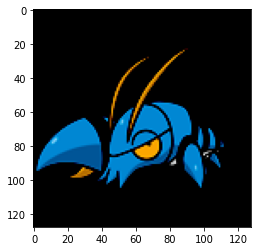

In [14]:
img = unknown_image_batch[0]
plt.imshow(tf.concat([img], 2))

# Training

In [15]:
%cd /content/drive/MyDrive/thesis_results/pokemon
wgan = WGANGP(loading=True)
%cd /content/drive/MyDrive/thesis_results/pokemon

/content/drive/MyDrive/thesis_results/pokemon
/content/drive/MyDrive/thesis_results/pokemon
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 1536)]      0         
                                                                 
 dense (Dense)               (None, 1, 1, 1536)        2359296   
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 1536)       6144      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 1, 1536)        0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 96)          0         
                                                                 
 up_sampling2d (UpSampling2D  (

In [ ]:
wgan.train(ds_train)

Epoch 1/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 2/300


0/1728 |                                                                                                   | ?…

Epoch 3/300


0/1728 |                                                                                                   | ?…

Epoch 4/300


0/1728 |                                                                                                   | ?…

Epoch 5/300


0/1728 |                                                                                                   | ?…

Epoch 6/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 7/300


0/1728 |                                                                                                   | ?…

Epoch 8/300


0/1728 |                                                                                                   | ?…

Epoch 9/300


0/1728 |                                                                                                   | ?…

Epoch 10/300


0/1728 |                                                                                                   | ?…

Epoch 11/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 12/300


0/1728 |                                                                                                   | ?…

Epoch 13/300


0/1728 |                                                                                                   | ?…

Epoch 14/300


0/1728 |                                                                                                   | ?…

Epoch 15/300


0/1728 |                                                                                                   | ?…

Epoch 16/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 17/300


0/1728 |                                                                                                   | ?…

Epoch 18/300


0/1728 |                                                                                                   | ?…

Epoch 19/300


0/1728 |                                                                                                   | ?…

Epoch 20/300


0/1728 |                                                                                                   | ?…

Epoch 21/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 22/300


0/1728 |                                                                                                   | ?…

Epoch 23/300


0/1728 |                                                                                                   | ?…

Epoch 24/300


0/1728 |                                                                                                   | ?…

Epoch 25/300


0/1728 |                                                                                                   | ?…

Epoch 26/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 27/300


0/1728 |                                                                                                   | ?…

Epoch 28/300


0/1728 |                                                                                                   | ?…

Epoch 29/300


0/1728 |                                                                                                   | ?…

Epoch 30/300


0/1728 |                                                                                                   | ?…

Epoch 31/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 32/300


0/1728 |                                                                                                   | ?…

Epoch 33/300


0/1728 |                                                                                                   | ?…

Epoch 34/300


0/1728 |                                                                                                   | ?…

Epoch 35/300


0/1728 |                                                                                                   | ?…

Epoch 36/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 37/300


0/1728 |                                                                                                   | ?…

Epoch 38/300


0/1728 |                                                                                                   | ?…

Epoch 39/300


0/1728 |                                                                                                   | ?…

Epoch 40/300


0/1728 |                                                                                                   | ?…

Epoch 41/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 42/300


0/1728 |                                                                                                   | ?…

Epoch 43/300


0/1728 |                                                                                                   | ?…

Epoch 44/300


0/1728 |                                                                                                   | ?…

Epoch 45/300


0/1728 |                                                                                                   | ?…

Epoch 46/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 47/300


0/1728 |                                                                                                   | ?…

Epoch 48/300


0/1728 |                                                                                                   | ?…

Epoch 49/300


0/1728 |                                                                                                   | ?…

Epoch 50/300


0/1728 |                                                                                                   | ?…

Epoch 51/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 52/300


0/1728 |                                                                                                   | ?…

Epoch 53/300


0/1728 |                                                                                                   | ?…

Epoch 54/300


0/1728 |                                                                                                   | ?…

Epoch 55/300


0/1728 |                                                                                                   | ?…

Epoch 56/300


0/1728 |                                                                                                   | ?…

/content/drive/MyDrive/thesis_results/pokemon
Epoch 57/300


0/1728 |                                                                                                   | ?…

Epoch 58/300


0/1728 |                                                                                                   | ?…

Epoch 59/300


0/1728 |                                                                                                   | ?…

Epoch 60/300


0/1728 |                                                                                                   | ?…

In [ ]:
wgan.generate_samples()

In [ ]:
wgan.saving_models()

# Evaluation

In [ ]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
import math
from tqdm.autonotebook import tqdm
import numpy as np
def compute_embeddings(dataloader, count, generated = False):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        if generated:
          z = tf.random.normal((batch, 1, 1, noise_dim))
          images = wgan.Gen(z, training=False)
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)

count = math.ceil(10000/batch)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(ds_train, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(ds_train, count, generated = True)

real_image_embeddings.shape, generated_image_embeddings.shape

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

((10016, 2048), (10016, 2048))

In [ ]:
import scipy
def calculate_fid(real_embeddings, generated_embeddings):
  # calculate mean and covariance statistics
  mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
  mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
fid

1765.871986776938

In [ ]:
# 1765.871986776938

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


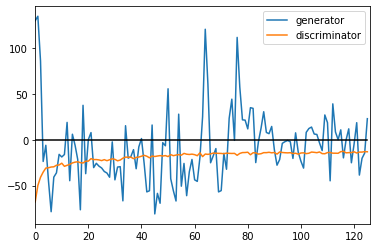

In [ ]:
plt.plot(wgan.gen_losses, label='generator')
plt.plot(wgan.disc_losses, label='discriminator')
ax = plt.axes()
ax.set(xlim=(0, wgan.gen_losses.shape[0]))
plt.legend()
plt.plot(np.zeros(wgan.gen_losses.shape[0]), 'black')
plt.show()